## Disclaimer
This notebook is only working under the versions:

- JuMP 0.19 (unreleased, but currently in master)

- MathOptInterface 0.4.1

- GLPK 0.6.0

**Description**: Shows how to find the Chebyshev center of a polyhedron.

**Author**: Iain Dunning

**License**: <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.

# Finding the Chebyshev Center using JuMP

*This model is drawn from section 4.3.1 of the book [**Convex Optimization** by Boyd and Vandenberghe](http://stanford.edu/~boyd/cvxbook/)*

Given a polyhedron described as a set of hyperplanes, i.e.
$$
P = \left\{ x \mid A x \leq b \right\}
$$
find the largest Euclidean ball that lies inside the polyhedron. The center of this ball is known as the **Chebyshev center** of the polyhedron.

This problem can be formulated a linear optimization problem. Let $x$ be the center of the ball, and $r$ be the radius of the ball. Our ball can then be expressed as
$$
B = \left\{ x + u \mid \|u\|_2 \leq r \right\}
$$
and we can express the constraint that the ball lies in a halfspace as $A_i^\prime x \leq b_i$, i.e.
$$
A_i^\prime \left ( x + u \right) \leq b_i \quad \forall u:\|u\|_2 \leq r
$$

We can then use the fact that
$$
\sup_{\|u\|_2 \leq r} A_i^\prime x = r \| A_i \|_2
$$
to simplify that constraint to the linear equality
$$
A_i^\prime x + r \| A_i \|_2 \leq b_i
$$
which allows us to express the problem as
$$
\begin{alignat}{2}
             \max \  & r \\
\text{subject to} \  & A_i^\prime x + \left\| A_i \right\| r \leq b_i
\end{alignat}
$$

In [1]:
# Load JuMP
using JuMP
using MathOptInterface
# Load solver package
using GLPK
# shortcuts
const MOI = MathOptInterface
const MOIU = MathOptInterface.Utilities

MathOptInterface.Utilities

In [2]:
# Use a hyperplane representation of the polyhedron
# i.e. P = { x | Ax ≤ b }
n = 4
# Store LHS as vector-of-vectors
A = Vector{Float64}[
    [ 2, 1], [ 2,-1],
    [-1, 2], [-1,-2]]
b = ones(n)

# Build JuMP model
m = Model(optimizer = GLPK.GLPKOptimizerLP())
@variable(m, r)
@variable(m, x[1:2])
@objective(m, Max, 1r)
@constraint(m, P[i=1:4], sum(A[i][j]*x[j] for j in eachindex(x)) + norm(A[i])*r <= b[i])
# solve problem
JuMP.optimize(m)

In [3]:
# Where is the center?
print(JuMP.resultvalue.(x))

[-0.0, -0.0]

In [4]:
JuMP.resultvalue(r)

0.4472135954999579

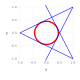

In [5]:
# Use Gadfly to display the solution
using Gadfly
Gadfly.set_default_plot_size(8cm, 8cm)
# Plot lines over [-1.5, 1.5]
domain = linspace(-1, +1)
# Plot circle across all angles
θ = linspace(0,2π)
plot(
# a_1 x_1 + a_2 x_2 = b
# --> x_2 = (b - a_1 x_1)/a_2
[layer(x=domain,
       y=(b[i]-A[i][1]*domain)/A[i][2],
       Geom.line,
       Theme(line_width=2px,
             default_color=colorant"blue")) for i in 1:4]...,
# x_1' = x_1 + rθ
# x_2' = x_2 + rθ
layer(x=JuMP.resultvalue(x[1]) + JuMP.resultvalue(r)*cos.(θ),
      y=JuMP.resultvalue(x[2]) + JuMP.resultvalue(r)*sin.(θ),
      Geom.path,
      Theme(line_width=5px,
            default_color=colorant"red")),
Coord.Cartesian(ymin=-1,ymax=+1)
)